GPU Allocated before delete: 11634.48779296875 MB
GPU Reserved before delete: 11638.0 MB
GPU Allocated after delete:  0.42138671875 MB
GPU Reserved after delete:  2.0 MB


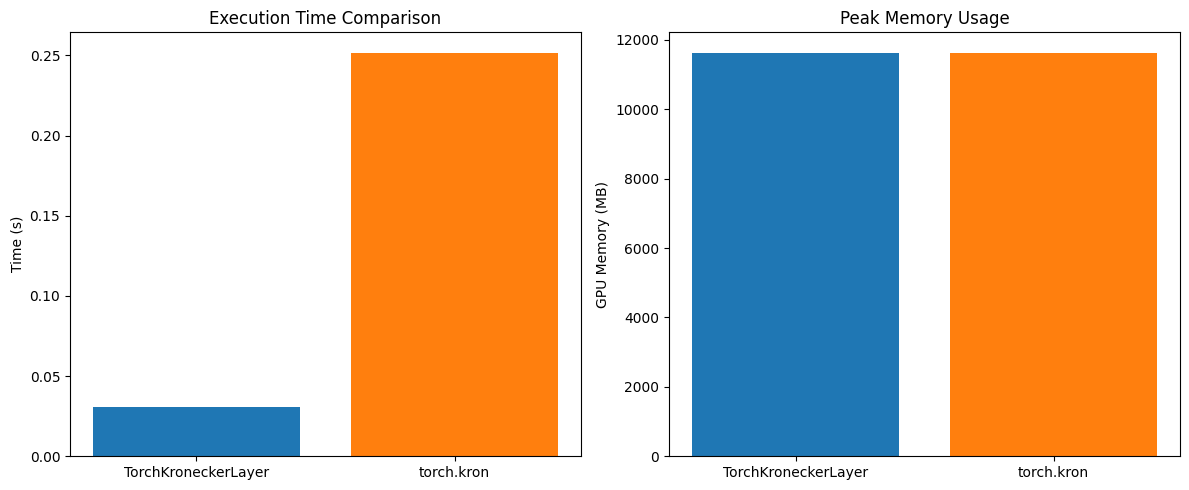

In [3]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from cirkit.backend.torch.layers.inner import TorchKroneckerLayer
import gc
import psutil

# ─── Configuration ─────────────────────────────
MATRIX_SIZE = 235 # Change this to any integer for NxN matrices
BATCH_SIZE = 1
NUM_FOLDS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ───────────────────────────────────────────────

def create_input(matrix_size):
    a = torch.randn(matrix_size, matrix_size, device=DEVICE).flatten()
    b = torch.randn(matrix_size, matrix_size, device=DEVICE).flatten()
    return torch.stack([a, b]).unsqueeze(0).to(DEVICE)

x_in = create_input(MATRIX_SIZE)

layer = TorchKroneckerLayer(
    num_input_units=MATRIX_SIZE**2,
    arity=2,
    num_folds=NUM_FOLDS
).to(DEVICE)

def measure(func, *args):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start = time.perf_counter()
    result = func(*args)
    torch.cuda.synchronize()  # Wait for CUDA ops to complete
    elapsed = time.perf_counter() - start
    memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

    return result, elapsed, memory

def align_blocks(layer_output, matrix_size):
    reshaped = layer_output.view(matrix_size, matrix_size, matrix_size, matrix_size)
    permuted = reshaped.permute(0, 2, 1, 3)
    return permuted.contiguous().view(matrix_size**2, matrix_size**2)


output1, t1, m1 = measure(layer, x_in)
#output1 = align_blocks(output1, MATRIX_SIZE)

print("GPU Allocated before delete:", 
      torch.cuda.memory_allocated() / 1024**2, "MB")
print("GPU Reserved before delete:", 
      torch.cuda.memory_reserved() / 1024**2, "MB")

#output1_cpu = align_blocks(output1.cpu(),MATRIX_SIZE)  # Move to RAM before deletion[2][4]
# 1) Remove the name
del output1
del layer

# 2) Force Python to collect any unreferenced objects
gc.collect()

# 3) Empty PyTorch's CUDA cache
torch.cuda.empty_cache()

print("GPU Allocated after delete: ", 
      torch.cuda.memory_allocated() / 1024**2, "MB")
print("GPU Reserved after delete: ", 
      torch.cuda.memory_reserved() / 1024**2, "MB")

a = x_in[0, 0].view(MATRIX_SIZE, MATRIX_SIZE)
b = x_in[0, 1].view(MATRIX_SIZE, MATRIX_SIZE)
del x_in
output2, t2, m2 = measure(torch.kron, a, b)
#output2_cpu = output2.cpu() 
del a
del b
del output2
gc.collect()
torch.cuda.empty_cache()

#print(f"RAM before cleanup: {psutil.Process().memory_info().rss/1024**2:.2f} MB")
#are_equal = torch.allclose(output1_cpu, output2_cpu, atol=1e-4)  # Increased tolerance[3][5]
#print(f"Outputs equal? {are_equal}")

# New cleanup section
#del output1_cpu, output2_cpu
#gc.collect()  # Force Python GC to reclaim RAM[2][3]

# Optional verification
#print(f"RAM after cleanup: {psutil.Process().memory_info().rss/1024**2:.2f} MB")

# Visualization
implementations = ['TorchKroneckerLayer', 'torch.kron']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
axes[0].bar(implementations, [t1, t2], color=['#1f77b4', '#ff7f0e'])
axes[0].set_ylabel('Time (s)')
axes[0].set_title('Execution Time Comparison')

# Memory comparison
axes[1].bar(implementations, [m1, m2], color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('GPU Memory (MB)')
axes[1].set_title('Peak Memory Usage')

plt.tight_layout()
plt.show()
